# MEN

*Nb* : jupyter notebook --NotebookApp.iopub_data_rate_limit=1000000 men.ipynb

##### Internship project summary (FR)

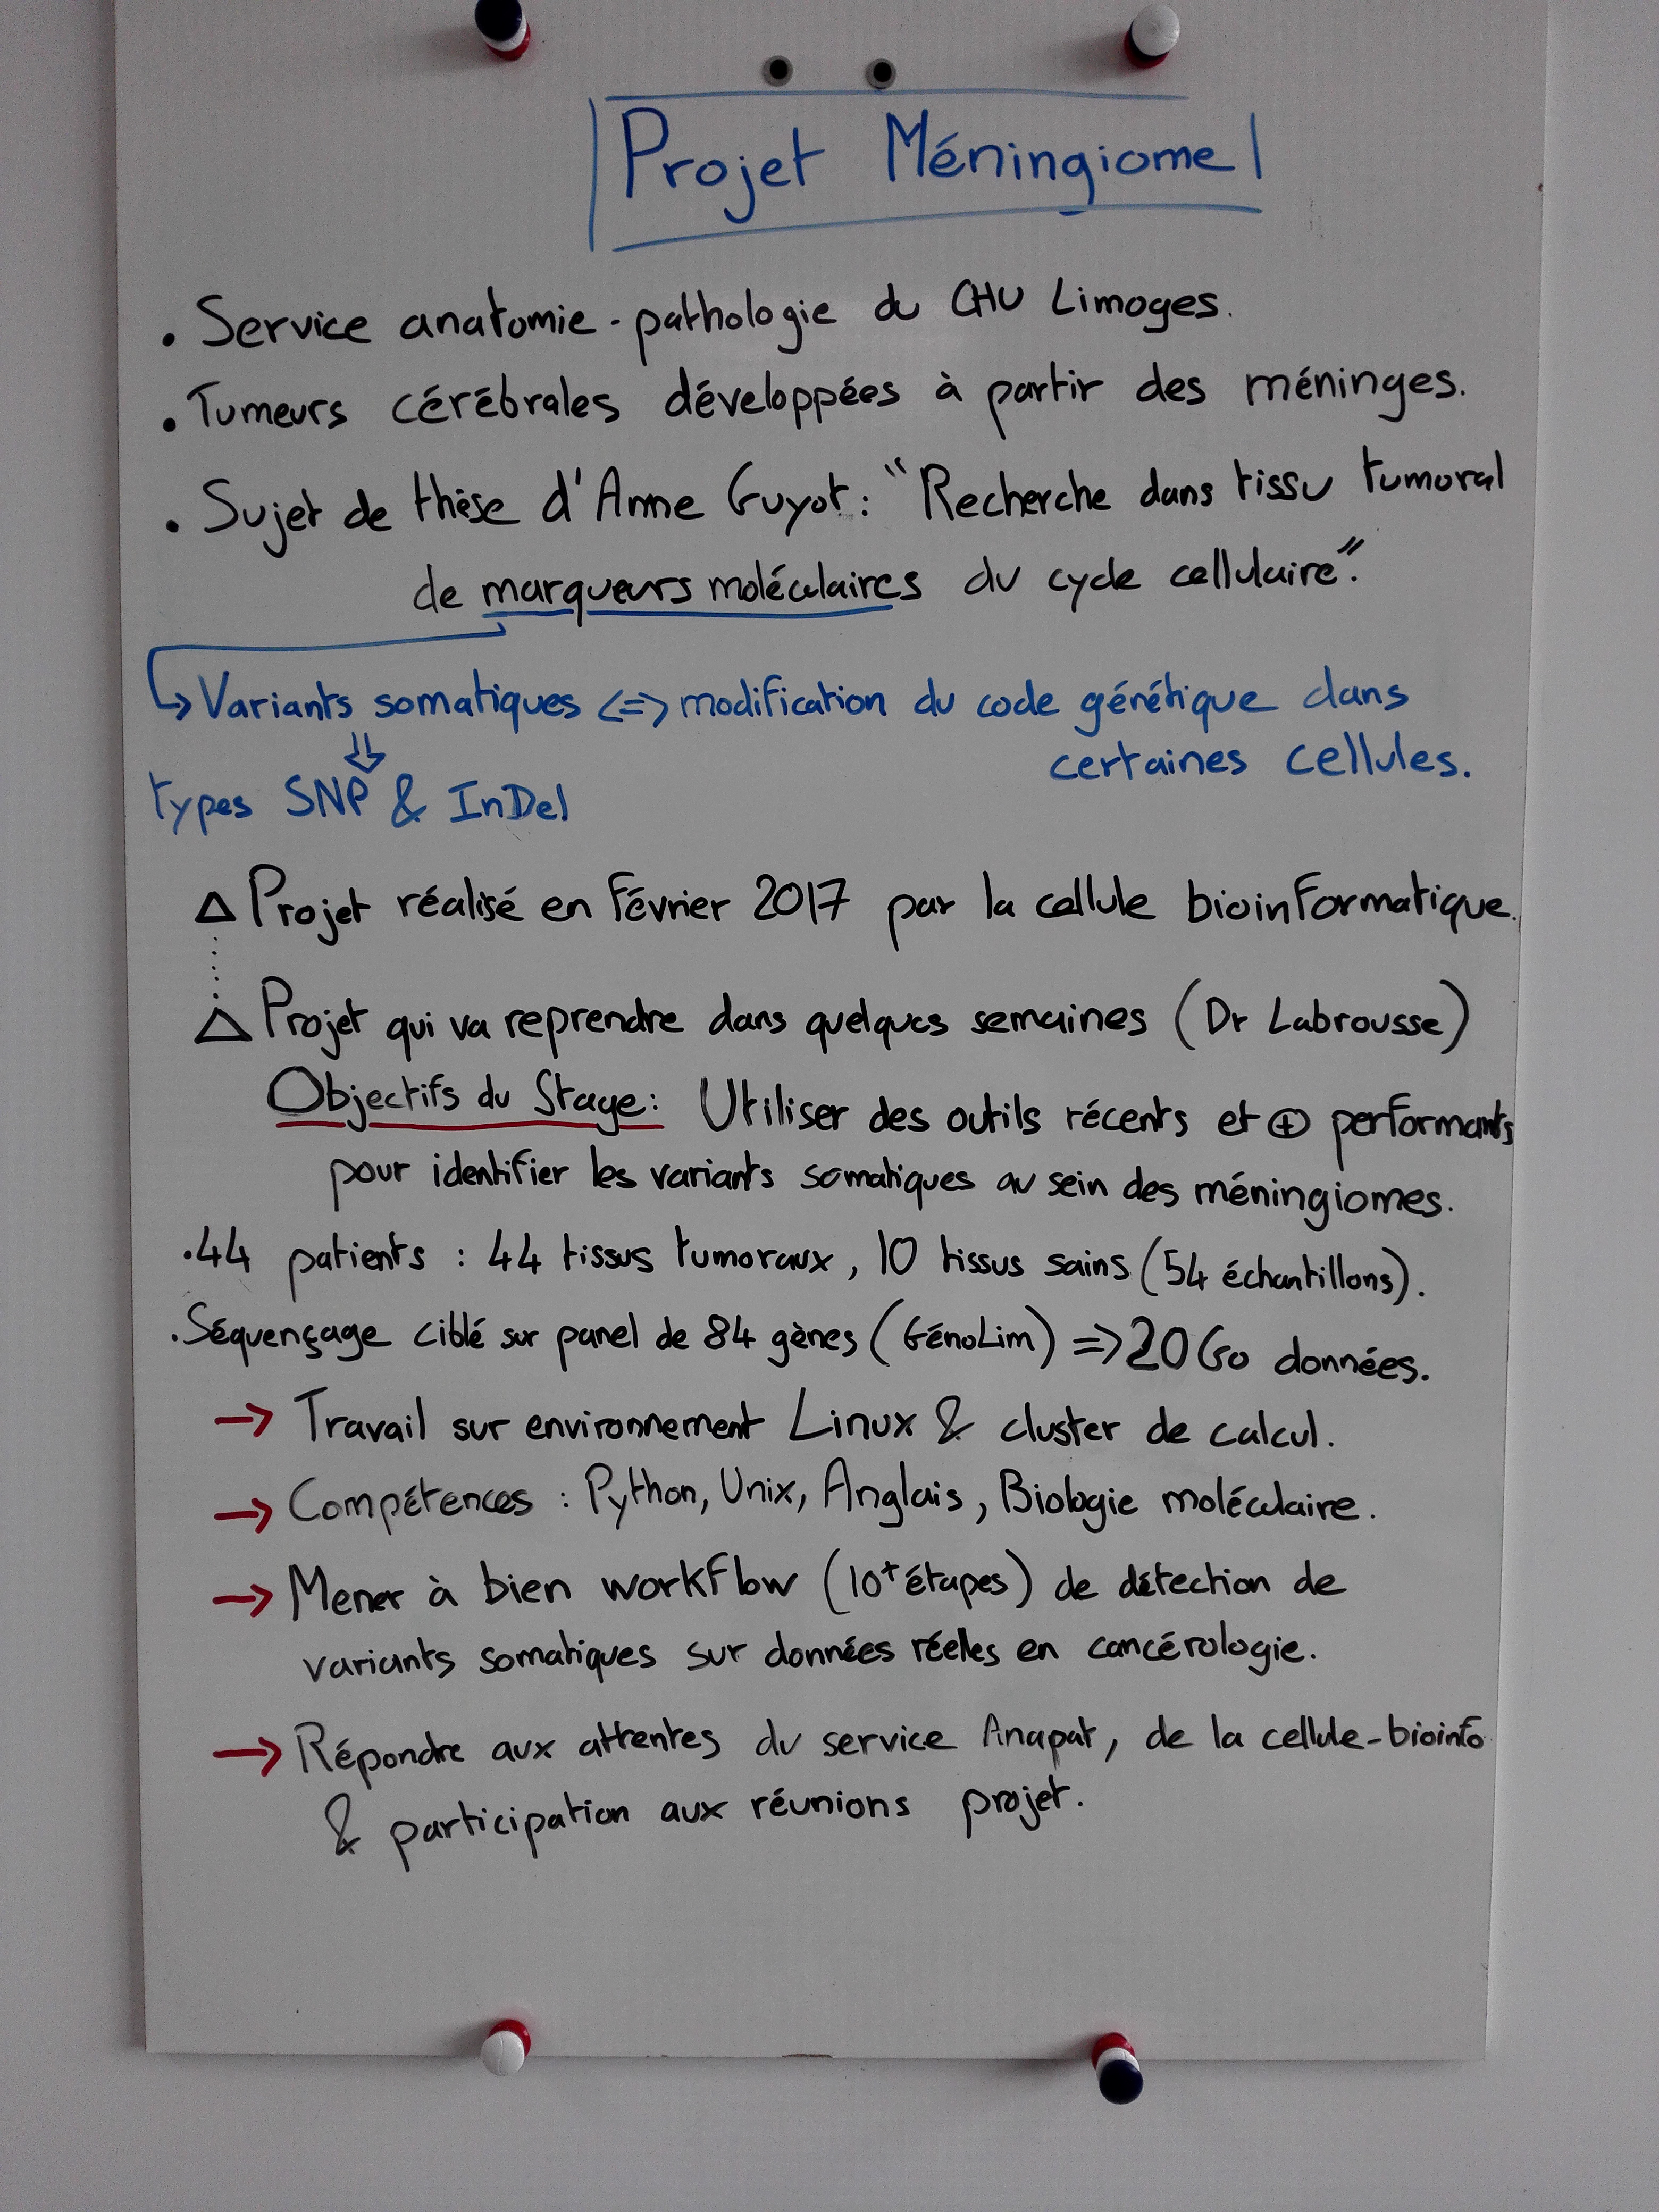

In [1]:
display < ./Picture/recap_start_project.jpg;

##### Links

[G.Form](https://docs.google.com/forms/d/15brKAKfzhlp2G2JirapQFgEijQM4jjoril3miqRUs20/edit#response=ACYDBNj_gw5x6NGVheXFapAuXMaKs5ifeoCuPLQ0QkUOgevi3bDJsS4aTs88kG8) <br>
[Overview](https://docs.google.com/presentation/d/1vlmkhJnw6OVaX5gvfTLsXwnBjCpns4kZ0L7WVGQmjrs/edit?usp=sharing) (not up to date yet, currently based on GLIO project overview) <br>
[Overleaf](https://www.overleaf.com/read/nkwvbkycvbfn)

## 0) Installs

### 0.1) Latest BWA @CALI

##### BWA version @CALI

In [ ]:
### CODE ###
module load bio;
bwa;
# Version: 0.7.10-r789

##### Unable to "git clone" @CALI, thus do it locally, then load @CALI

In [ ]:
### CODE ###
git clone https://github.com/lh3/bwa.git;
scp -r bwa scaonp01@cali.unilim.fr://home/scaonp01/Software;

##### Now connect to CALI

In [ ]:
cd /home/scaonp01/Software;
mv bwa Bwa && cd $_;
make;
./bwa;
# 0.7.17-r1194-dirty

## 1) Context

### 1.1) Biology

### 1.2) Bioinformatics

### 1.3) Internship

## 2) Data

### 2.1) Panel

Primers were designed to screen the 84 genes panel. <br> For each gene, some exons are targeted by a primer pair. <br> Primers "validated design" is specified in the file named "IAD92261_173_Designed.bed".

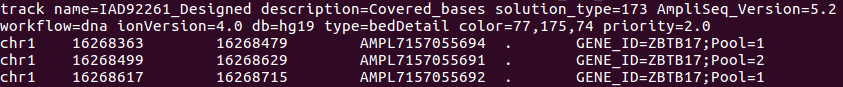

In [2]:
display < ./Picture/panel.png;

#### 2.1.1) Amplicons.bed

A 4 columns BED file containing amplicons informations is needed for further analysis.

In [ ]:
### CODE ###
# All the needed infos are contained within the "IAD92261_173_Designed.bed" file, i.e :
# chr, start_pos, end_pos, gene_name+amplicon_name
# For "chr", "start_pos" and "end_pos", this is straighforward awk, just use $1, $2 & $3
# For "gene_name+amplicon_name", we have "amplicon_name" info in $4,
# "gene_name" info is nested in $6, thus we use the awk match and capture a group (= gene_name) from the regex match
# awk match result is stored in an array (a). a[1] give us acces to the first "match group" within the regex match
# A "match group" is defined with surrounding parentheses inside the regex match
awk -F "\t" 'NR>1 {match($6, /=(.*);/, a)}; NR>1 {print $1"\t"$2"\t"$3"\t"a[1]"_"$4}' IAD92261_173_Designed.bed \
> amplicons_4cols.bed;

#### 2.1.2) Genes.bed

A 4 columns BED file containing genes informations is needed for further analysis.

In [ ]:
### CODE ###
# Get gene list from hg19 panel
awk -F "\t" 'NR>1 {match($6, /=(.*);/, a)}; NR>1 {print a[1]}' IAD92261_173_Designed.bed \
| sort -u \
> panel_gene_list.txt;
# Get a two cols file containing chr_name & gene_name (to help retrieve chr info associated to each gene later on)
awk -F "\t" 'NR>1 {match($6, /=(.*);/, a)}; NR>1 {print $1"\t"a[1]}' IAD92261_173_Designed.bed \
| sort -u \
> chr_gene.tsv;
# Below is our info source to map gene names to actual start & end positions in hg19
# Note that, from this GFF file, chr info is not straightforward to retrieve for a given gene,
# Thus we will use the previously created "chr_gene.tsv" file to map gene names to their chr
url='ftp://ftp.ncbi.nlm.nih.gov/genomes/Homo_sapiens/ARCHIVE';
axel -q $url/ANNOTATION_RELEASE.105/GFF/ref_GRCh37.p13_top_level.gff3.gz;
# Create a file which will be grep input for regular gene names
sed 's/^/Name=/' panel_gene_list.txt > panel_gene_list_grep_search.txt;
sed -i 's/$/;/' panel_gene_list_grep_search.txt;
# Create a file which will be grep input for synonym gene names
sed 's/^/gene_synonym=/' panel_gene_list.txt > panel_gene_list_grep_search_synonym.txt;
sed -i 's/$/;/' panel_gene_list_grep_search_synonym.txt;
# grep for regular gene names
zgrep -f panel_gene_list_grep_search.txt ref_GRCh37.p13_top_level.gff3.gz \
| awk -F '\t' '{if($3 == "gene") print $0}' \
> candidates.gff3;
# grep for synonym gene names
zgrep -f panel_gene_list_grep_search_synonym.txt ref_GRCh37.p13_top_level.gff3.gz \
| awk -F '\t' '{if($3 == "gene") print $0}' \
> candidates_synonym.gff3;
# Keep only needed infos from previous grep results
awk -F '\t' '{match($9, /Name=(.*);Db/, a); print $4"\t"$5"\t"a[1]}' candidates.gff3 \
> s_e_g.tsv;
awk -F '\t' '{match($9, /gene_synonym=(.*);part/, a); print $4"\t"$5"\t"a[1]}' candidates_synonym.gff3 \
>> s_e_g.tsv;
# Sort these two files on their common column before merging them. This merge will help us link gene_name to chr
sort -k2 chr_gene.tsv > chr_gene_sorted.tsv;
sort -k3 s_e_g.tsv > s_e_g_sorted.tsv;
# Join
join -1 2 -2 3 -a 1 -t $'\t' chr_gene_sorted.tsv s_e_g_sorted.tsv > genes_4cols.tsv;
# Show that some gene have more than one entry (this is a problem)
awk -F '\t' '{print $1}' genes_4cols.tsv | sort | uniq -c | sort -nr | he -5;
      2 PPP2R3B
      2 PPP2R2D
      2 PPP2R1B
      2 CDK7
      1 ZBTB17
# Manually inspect IAD92261_173_Designed.bed to define which entry is the undesired one (for genes with 2 locations)
# Then use sed to remove those undesired entries
sed -i '/PPP2R3B\tchrX\t244668/d' genes_4cols.tsv;
sed -i '/PPP2R2D\tchr10\t25720/d' genes_4cols.tsv;
sed -i '/PPP2R1B\tchr11\t799/d' genes_4cols.tsv;
sed -i '/CDK7\tchr5\t17975/d' genes_4cols.tsv;
# Reorder like a real BED file
awk -F '\t' '{print $2"\t"$3"\t"$4"\t"$1}' genes_4cols.tsv > temp.tsv;
rm genes_4cols.tsv;
# Sort by chr_name then by start_pos
sort -k1,1V -k2,2n -o genes_4cols.tsv temp.tsv;
# Caution, GFF files (from which we extracted start & end infos) are 1-based (see : http://gmod.org/wiki/GFF3)
# We want to create a BED file, which is 0-based. Thus we need to correct for this using awk
awk -F '\t' '{print $1"\t"$2-1"\t"$3-1"\t"$4}' genes_4cols.tsv > genes_4cols.bed;
# Remove useless files
rm s_e_g* candidates* chr_gene* panel_gene* temp.tsv genes_4cols.tsv ref_GRCh37.p13_top_level.gff3.gz;

### 2.2) Raw reads

Describe samples : number, size, etc...

### 2.3) Reference genome

hg19

### 2.4) Known SNVs

dbSNP

### 2.5) Known somatic variants

COSMIC

### 2.6) Pop info

GATK "hapmap"

## 3) Pre-processing

### 3.1) Raw reads quality control

##### FastQC version XXX

In [ ]:
### CODE ###
ls;

##### MultiQC version XXX

In [ ]:
### CODE ###
ls;

### 3.2) Reads trimming / filtering

Explain why we should or not trim / filter.

## 4) Pre-variant calling

## 5) Variant calling

## 6) Annotations & filters